In [14]:
%reload_ext autoreload
%autoreload 2

import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
from astropy import units as u
from astropy.constants import k_B, h, c, m_p, m_e
k_B = k_B.to(u.erg / u.K)
h = h.to(u.erg * u.s)
c = c.to(u.cm / u.s)
m_p = m_p.to(u.g)
m_e = m_e.to(u.g)

import plot_utils as pu
import utils as ut
from data_utils import data_dic
from data_utils import atomic_data_ext as ate
from data_utils import atomic_data as at
import data_utils as du

In [15]:
M = len(data_dic['t8000']['data'])

stars = ['t6000', 't8000']
vars = ['NHI', 'NHII', 'NH-', 'NHI1', 'NHI2', 'NHI3']
results = {star: {} for star in stars}
for key, temp in enumerate(stars): 
    data = data_dic[temp]['data']
    sols_saha = np.zeros((M, 3))
    sols_boltzman = np.zeros((M, 3))
    #print(temp)

    for i in range(M):
        P_e = np.array(data['Pe'])[i] * u.erg / u.cm**3
        T = np.array(data['T'])[i] * u.K

        # Solving Saha equation
        N_e = P_e / (k_B * T) 
        a = ut.saha(N_e, T, at['HII']['U'], at['HI']['U'], at['HI']['ion_en'])
        b = ut.saha(N_e, T, at['HI']['U'], at['H-']['U'], at['H-']['ion_en'])
        matrix_saha = ut.matrix_saha(a, b)
        rhs_saha = np.array([0,0,N_e.value])
        sols_saha_ = np.linalg.solve(matrix_saha, rhs_saha)
        sols_saha[i, :] = sols_saha_

        # Solving Boltzmann equation
        alpha = ut.boltzmann(at['HI']['g'][0], at['HI']['g'][1],
                             at['HI']['ex_en'][0], at['HI']['ex_en'][1], T)
        beta = ut.boltzmann(at['HI']['g'][1], at['HI']['g'][2],
                            at['HI']['ex_en'][1], at['HI']['ex_en'][2], T)
        
        matrix_boltzman = ut.matrix_boltz(alpha, beta)
        NHI = sols_saha_[0]
        rhs_boltzman = np.array([NHI,0,0])
        sols_boltzman_ = np.linalg.solve(matrix_boltzman, rhs_boltzman)
        sols_boltzman[i, :] = sols_boltzman_

    P_e = np.array(data['Pe'])
    T = np.array(data['T'])
    N_e = P_e / (k_B.value * T) 
    results[temp]['Ne'] = list(N_e)
    results[temp]['NHI'] = list(sols_saha[:, 0])
    results[temp]['NHII'] = list(sols_saha[:, 1])
    results[temp]['NH-'] = list(sols_saha[:, 2])
    results[temp]['NHI1'] = list(sols_boltzman[:, 0])
    results[temp]['NHI2'] = list(sols_boltzman[:, 1])
    results[temp]['NHI3'] = list(sols_boltzman[:, 2])

In [16]:
# save results dic as json
import json
with open('../results/abundances.json', 'w') as fp:
    json.dump(results, fp)

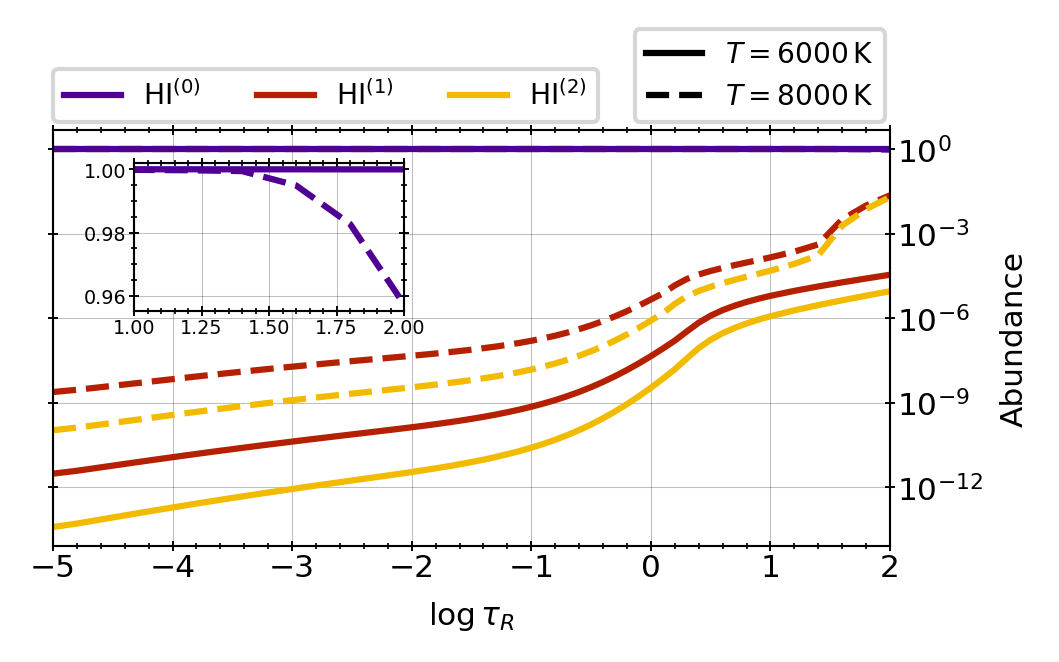

In [20]:
Fig = pu.Figure(theme='default', ts=2.95)
fig = Fig.fig
axes = Fig.axes
fig_size = Fig.fig_size
ratio = Fig.ratio
fs = Fig.fs
ts = Fig.ts

ax = axes[0][0]

# add new ax for inside plot
ax2 = fig.add_axes([0.2, 0.545, 0.25, 0.275])
Fig.customize_axes(ax2, ts=1.8)

lgTauR = data['lgTauR']

lss = ['-','--']
cmap = mpl.colormaps['gnuplot']
M = 3
cs = [cmap(i) for i in np.linspace(0.1, 0.9, M)]
labels = [r'HI$^{(0)}$', r'HI$^{(1)}$', 'HI$^{(2)}$']
for i, temp in enumerate(['t6000', 't8000']): 
    N_HI = np.array(results[temp]['NHI'])
    N_HI1 = np.array(results[temp]['NHI1'])
    N_HI2 = np.array(results[temp]['NHI2'])
    N_HI3 = np.array(results[temp]['NHI3'])
    ax.plot(lgTauR, N_HI1/N_HI, ls=lss[i], c=cs[0])
    ax2.plot(lgTauR, N_HI1/N_HI, ls=lss[i], c=cs[0])
    ax.plot(lgTauR, N_HI2/N_HI, ls=lss[i], c=cs[1])
    ax.plot(lgTauR, N_HI3/N_HI, ls=lss[i], c=cs[2])

ax.set_xlabel(r'$\log \tau_R$', fontsize=fs*ts)
ax.set_ylabel(r'Abundance', fontsize=fs*ts)



handles1 = []
for i in range(3):
    handles1.append(mlines.Line2D([], [], color=cs[i], label=labels[i]))
legend1 = ax.legend(handles=handles1, loc=(0, 1.02), fontsize=0.9*fs*ts, ncols=3)

# Second legend
handles2 = []
labels_2 = [r'$T=6000 \, \text{K}$', r'$T=8000 \, \text{K}$']
for i in range(2):
    handles2.append(mlines.Line2D([], [], color='k', linestyle=lss[i], label=labels_2[i]))
legend2 = ax.legend(handles=handles2, loc=(0.695,1.02), fontsize=0.9*fs*ts, ncols=1)

# Add the first legend back into the plot
ax.add_artist(legend1)

ax.set_xlim(np.min(lgTauR), np.max(lgTauR))
ax.set_yscale('log')


ax2.set_xlim(1, np.max(lgTauR))


Fig.customize_axes(ax, ylabel_pos='right')

savefold = '../figures/'
if not os.path.exists(savefold):
    os.makedirs(savefold)
figname = f'H_abundances_ex.png'
savepath = savefold + figname

fig_h = Fig.fig_height
fig_w = Fig.fig_width
x0, y0 = 0.1*fig_w, -0.08*fig_h
x1, y1 = 1.03*fig_w, 1.09*fig_h
Fig.save(savepath, 
         bbox_inches=mpl.transforms.Bbox([[x0, y0], [x1, y1]]))


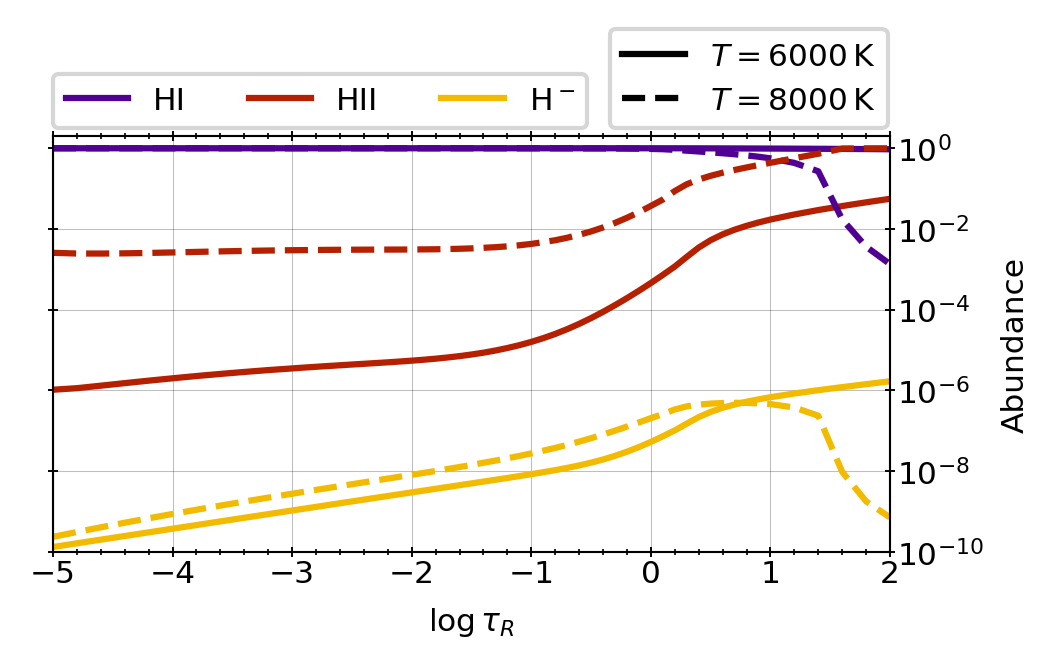

In [21]:
fig = pu.Figure(theme='default', ts=2.95)
axes = fig.axes
fig_size = fig.fig_size
ratio = fig.ratio
fs = fig.fs
ts = fig.ts

ax = axes[0][0]

lgTauR = data['lgTauR']

lss = ['-','--']
cmap = mpl.colormaps['gnuplot']
M = 3
cs = [cmap(i) for i in np.linspace(0.1, 0.9, M)]
labels = [r'HI', r'HII', 'H$^-$']
for i, temp in enumerate(['t6000', 't8000']): 
    N_HI = np.array(results[temp]['NHI'])
    N_HII = np.array(results[temp]['NHII'])
    N_Hm = np.array(results[temp]['NH-'])
    N_H = N_HI + N_HII + N_Hm
    ax.plot(lgTauR, N_HI/N_H, ls=lss[i], c=cs[0])
    ax.plot(lgTauR, N_HII/N_H, ls=lss[i], c=cs[1])
    ax.plot(lgTauR, N_Hm/N_H, ls=lss[i], c=cs[2])

ax.set_xlabel(r'$\log \tau_R$', fontsize=fs*ts)
ax.set_ylabel(r'Abundance', fontsize=fs*ts)

ax.set_xlim(np.min(lgTauR), np.max(lgTauR))
ax.set_ylim(1e-10, 2)
ax.set_yscale('log')

handles1 = []
for i in range(3):
    handles1.append(mlines.Line2D([], [], color=cs[i], label=labels[i]))
legend1 = ax.legend(handles=handles1, loc=(0, 1.02), fontsize=fs*ts, ncols=3)

# Second legend
handles2 = []
labels_2 = [r'$T=6000 \, \text{K}$', r'$T=8000 \, \text{K}$']
for i in range(2):
    handles2.append(mlines.Line2D([], [], color='k', linestyle=lss[i], label=labels_2[i]))
legend2 = ax.legend(handles=handles2, loc=(0.665,1.02), fontsize=fs*ts, ncols=1)

# Add the first legend back into the plot
ax.add_artist(legend1)


fig.customize_axes(ax, ylabel_pos='right')

savefold = '../figures/'
if not os.path.exists(savefold):
    os.makedirs(savefold)
figname = f'H_abundances.png'
savepath = savefold + figname

fig_h = fig.fig_height
fig_w = fig.fig_width
x0, y0 = 0.1*fig_w, -0.08*fig_h
x1, y1 = 1.03*fig_w, 1.09*fig_h
fig.save(savepath, 
         bbox_inches=mpl.transforms.Bbox([[x0, y0], [x1, y1]]))

In [22]:
from utils import sl

tauR_1 = 1
tauR_2 = 10
tauR = 10**lgTauR

#find id1 and idx2
id1 = np.argmin(np.abs(tauR - tauR_1))
id2 = np.argmin(np.abs(tauR - tauR_2))

x=''
temps = ['6000', '8000']
for temp in temps:
    for i, id in enumerate([id1, id2]):
        N_HI = results['t'+temp]['NHI']
        N_HII = results['t'+temp]['NHII']
        N_Hm = results['t'+temp]['NH-']
        N_HI1 = results['t'+temp]['NHI1']
        N_HI2 = results['t'+temp]['NHI2']
        N_HI3 = results['t'+temp]['NHI3']

        first = rf'\multirow{{2}}{{*}}{{{temp}}}' if i == 0 else f'{x:<10}'
        row = rf'{first} & ${tauR[id]:.2f}$ & {sl(N_HI[id])} & {sl(N_HII[id])} & {sl(N_Hm[id])} & {sl(N_HI1[id])} & {sl(N_HI2[id])} & {sl(N_HI3[id])} \\ \cline{{2-8}}'
        print(row)

\multirow{2}{*}{6000} & $1.00$ & $1.50 \times 10^{17}$ & $6.88 \times 10^{13}$ & $7.97 \times 10^{9}$ & $1.50 \times 10^{17}$ & $6.74 \times 10^{9}$ & $5.11 \times 10^{8}$ \\ \cline{2-8}
           & $10.00$ & $1.18 \times 10^{17}$ & $2.06 \times 10^{15}$ & $8.18 \times 10^{10}$ & $1.18 \times 10^{17}$ & $7.33 \times 10^{11}$ & $1.39 \times 10^{11}$ \\ \cline{2-8}
\multirow{2}{*}{8000} & $1.00$ & $1.56 \times 10^{16}$ & $6.04 \times 10^{14}$ & $3.34 \times 10^{9}$ & $1.56 \times 10^{16}$ & $7.17 \times 10^{10}$ & $1.28 \times 10^{10}$ \\ \cline{2-8}
           & $10.00$ & $5.92 \times 10^{15}$ & $4.59 \times 10^{15}$ & $4.82 \times 10^{9}$ & $5.92 \times 10^{15}$ & $8.49 \times 10^{11}$ & $2.87 \times 10^{11}$ \\ \cline{2-8}
